<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/img_processing/stop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case study to find STOP signals in images

Steps


*   Filter red parts
*   Find contours
*   Select octogon contours


In [49]:
import numpy as np
import skimage
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull

First we download an image with stop signal.

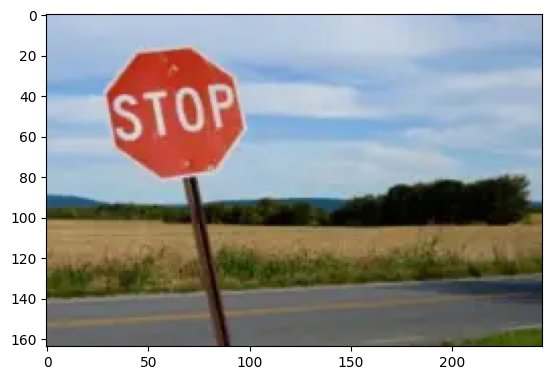

In [85]:
img  = skimage.io.imread('https://cdn.powa.com/baderscott.com/images/wp-content/uploads/2020/06/atlanta-ga-car-accident-lawyer-running-a-stop-signal-300x200-245-critical-desktop.jpg.webp')
# remove noise
#img = skimage.filters.gaussian(orig_img, 1)    # it may help
#img = orig_img
fig, ax = plt.subplots()
ax.imshow(img)

We convert the RGB image to HSV space to separate different shades of red. skimage scale HSV values to (0,1) interval.

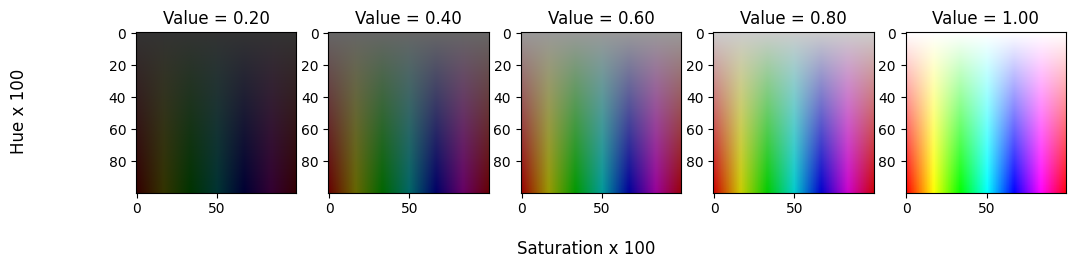

In [51]:
img_hsv = skimage.color.rgb2hsv(img)
isize = 100
h_scale = np.zeros((isize, isize, 3), dtype=img_hsv.dtype)
h = np.arange(0.0, 1.0, 1 / h_scale.shape[1])
for i in range(isize):
        h_scale[i,:,0] = h
        h_scale[:,i,1] = h
icols = 5
fig, ax = plt.subplots(ncols=icols, figsize=(12, 3))
fig.supxlabel('Saturation x 100')
fig.supylabel('Hue x 100')
for i in range(icols):
    v = i / icols + 0.20
    h_scale[:,:,2] = v
    ax[i].imshow(skimage.color.hsv2rgb(h_scale))
    ax[i].set_title(f'Value = {v:.2f}')

The hue should be greater than 0.6 and the saturation should be less than 0.1 for red color.

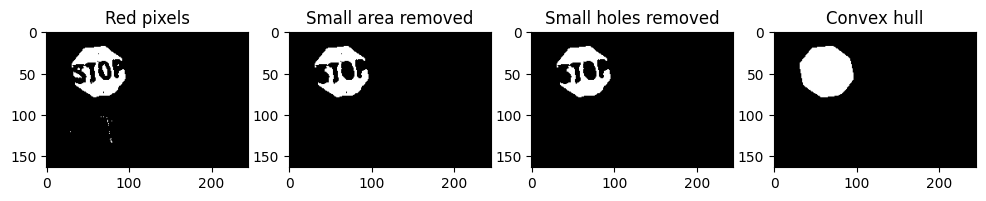

In [52]:
#img_bin = ((img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,0] < 0.1) & (img_hsv[:,:,2] > 0.3) | # red pixels
#            ((img_hsv[:,:,0] < 0.2) | (img_hsv[:,:,0] > 0.8)) & (img_hsv[:,:,1] < 0.3) & (img_hsv[:,:,2] > 0.8)) # white pixels
img1_bin = (img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,0] < 0.1) & (img_hsv[:,:,2] > 0.3) # red pixels
fig, ax = plt.subplots(ncols=4, figsize=(12, 3))
ax[0].set_title('Red pixels')
ax[0].imshow(img1_bin, cmap='gray')
img2_bin = skimage.morphology.remove_small_objects(img1_bin)
ax[1].set_title('Small area removed')
ax[1].imshow(img2_bin, cmap='gray')
img3_bin = skimage.morphology.remove_small_holes(img2_bin, 200)
ax[2].set_title('Small holes removed')
ax[2].imshow(img3_bin, cmap='gray')
img4_bin = skimage.morphology.convex_hull_image(img3_bin) # not useful if more signals are in the same image
ax[3].set_title('Convex hull')
ax[3].imshow(img4_bin, cmap='gray')

Stop signal at 64.1, 54.1


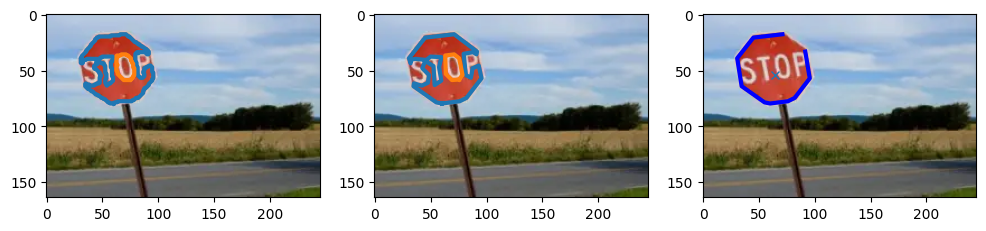

In [53]:
cnts = skimage.measure.find_contours(img3_bin)
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
for i in range(3):
    ax[i].imshow(img)
for contour in cnts:
    ax[0].plot(contour[:,1], contour[:,0], linewidth=3)
    appr = skimage.measure.approximate_polygon(contour, tolerance=1.5)
    ax[1].plot(appr[:,1], appr[:, 0], linewidth=3)
    hull = ConvexHull(appr)
    x = [appr[i,1] for i in hull.vertices]
    y = [appr[i,0] for i in hull.vertices]
    n = len(x)
    if 7 < n < 14:
        ax[2].plot(x, y, c='blue', linewidth=3)
        center = sum(x) / n, sum(y) / n
        ax[2].plot(center[0], center[1], 'x', linewidth=3)
        print(f"Stop signal at {center[0]:.1f}, {center[1]:.1f}")

Finaly test our algorithm with different images.
For this let's create a function for the simplicity.


In [82]:
def area(poly):
    """ calculate area of the polygon given as numpy array or list
    """
    coords = np.array(poly)
    coords1 = np.vstack((coords, coords[0]))
    return abs(np.sum((coords1[:-1, 0] - coords1[1:, 0]) * (coords1[:-1, 1] + coords1[1:, 1]))) / 2

def stop_signs(img):
    """ find stop traffic signal in image
        return a list with the positions of the possible stop traffic signals
    """
    img_hsv = skimage.color.rgb2hsv(img)
    img_bin = (img_hsv[:,:,1] > 0.6) & (img_hsv[:,:,0] < 0.1) & (img_hsv[:,:,2] > 0.3) # red pixels
    img_bin = skimage.morphology.remove_small_objects(img_bin)
    img_bin = skimage.morphology.remove_small_holes(img_bin, 200)
    cnts = skimage.measure.find_contours(img_bin)
    res = []
    total_area = img.shape[0] * img.shape[1]
    for contour in cnts:
        contour_area = area(contour)
        if contour_area / total_area > 0.002:   # skip small areas
            appr = skimage.measure.approximate_polygon(contour, tolerance=1.5)
            hull = ConvexHull(appr)
            x = [appr[i,1] for i in hull.vertices]
            y = [appr[i,0] for i in hull.vertices]
            n = len(x)
            if 7 < n < 14:
                res.append((sum(x) / n, sum(y) / n))
    return res

In [86]:
stop_signs(img)

[(64.1, 54.1)]

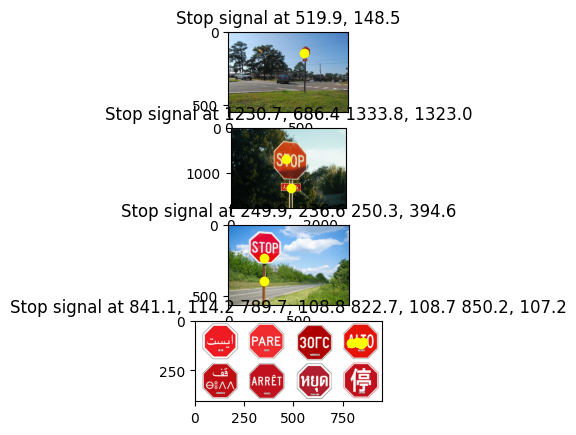

In [84]:
img_paths = ['https://media.defense.gov/2009/Dec/08/2000417879/825/780/0/091207-F-5660L-009.JPG',
            'https://i0.wp.com/the-peak.ca/wp-content/uploads/2023/10/wgog2-scaled.jpg?fit=2560%2C1779&ssl=1',
            'https://media.licdn.com/dms/image/C5112AQG1793I14gvQw/article-cover_image-shrink_720_1280/0/1520111767441?e=1710374400&v=beta&t=jHONA6BbmFnUiFYKHj8YDRZz9RmQbXY4W2eduLSBNgQ',
            'https://www.frontsigns.com/wp-content/uploads/2018/06/Stop-traffic-signs.jpg']
fig, ax = plt.subplots(nrows=len(img_paths))
for i, img_path in enumerate(img_paths):
    img = skimage.io.imread(img_path)
    ax[i].imshow(img)
    signs = stop_signs(img)
    s = np.array(signs)
    ax[i].plot(s[:,0], s[:,1], 'o', c="yellow")
    title = "Stop signal at"
    for sign in signs:
        title += f" {sign[0]:.1f}, {sign[1]:.1f}"
    ax[i].set_title(title)
